In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from scipy.fft import fft, rfft, ifft, fftfreq, irfft
from scipy import signal 
from datetime import datetime
from sklearn.cross_decomposition import CCA


In [2]:
# read the data 
eyes_test =  pd.read_csv('eye_open_close_ExG.csv')
ssvep_trial = pd.read_csv('test_ExG.csv')

## Need to high pass filter the data first to get rid of DC offset (otherwise, we can't see the FFT) 

In [3]:

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

## Separate Leon's eyes open and close and Plot

(75184,)
(37592,)


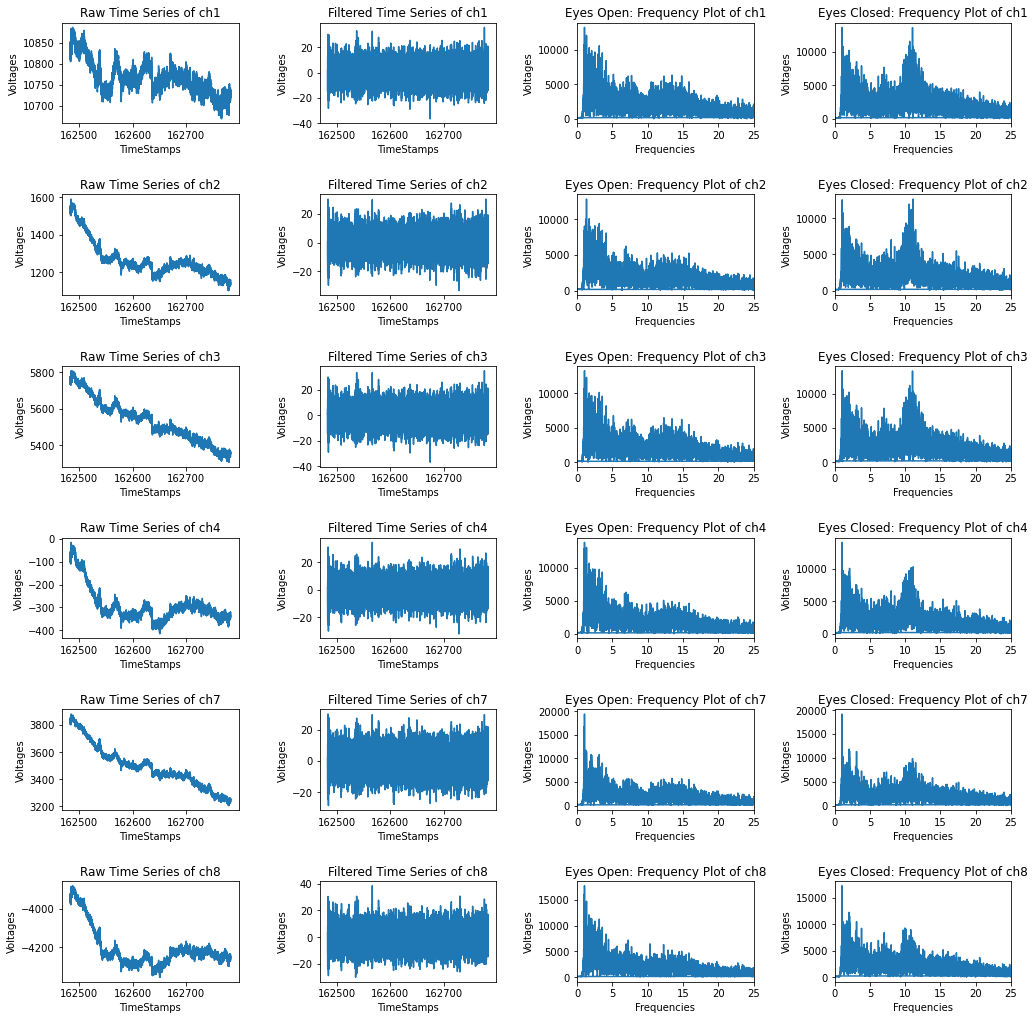

In [4]:
SAMPLE_RATE = 250 
sample_points = eyes_test.shape[0]
channels = eyes_test.columns[1:]

fig, ax = plt.subplots(len(channels),4, figsize=(15, 15))
fig.tight_layout(pad=5.0)

for index, ch in enumerate(channels):
    time_series = eyes_test[ch]
    filtered_y = butter_highpass_filter(time_series.values, cutoff=1, fs=SAMPLE_RATE, order=5)
        
    ax[index, 0].plot(eyes_test['TimeStamp'], time_series.values)
    ax[index, 0].set_xlabel('TimeStamps')
    ax[index, 0].set_ylabel('Voltages')
    ax[index, 0].set_title('Raw Time Series of ' + ch)
    
    
    ax[index, 1].plot(eyes_test['TimeStamp'], filtered_y)
    ax[index, 1].set_xlabel('TimeStamps')
    ax[index, 1].set_ylabel('Voltages')
    ax[index, 1].set_title('Filtered Time Series of ' + ch)
    
    
    halfway = int(sample_points/2) 
    eyes_open = filtered_y[:halfway]
    N = eyes_open.shape[0]
    xf = fftfreq(N, 1 / SAMPLE_RATE)
    yf = np.abs(fft(eyes_open))      
    ax[index, 2].plot(xf, yf)
    ax[index, 2].set_xlabel('Frequencies')
    ax[index, 2].set_ylabel('Voltages')
    ax[index, 2].set_title('Eyes Open: Frequency Plot of ' + ch)
    ax[index, 2].set_xlim([0,25])
    
    
    eyes_closed = filtered_y[halfway:]
    N = eyes_closed.shape[0]
    xf = fftfreq(N, 1 / SAMPLE_RATE)
    yf = np.abs(fft(eyes_closed))      
    ax[index, 3].plot(xf, yf)
    ax[index, 3].set_xlabel('Frequencies')
    ax[index, 3].set_ylabel('Voltages')
    ax[index, 3].set_title('Eyes Closed: Frequency Plot of ' + ch)
    ax[index, 3].set_xlim([0,25])
    
print(filtered_y.shape)
print(eyes_open.shape)
## CCA print(eyes_closed.shape)


## Perform CCA on Raw Data 

In [5]:

class CCAAnalysis:
    """Canonical Correlation Analysis for SSVEP paradigm"""
    def __init__(self, freqs, win_len, s_rate, n_harmonics=1):
        """
        Args:
            freqs (list): List of target frequencies
            win_len (float): Window length
            s_rate (int): Sampling rate of EEG signal
            n_harmonics (int): Number of harmonics to be considered
        """
        self.freqs = freqs
        self.win_len = win_len
        self.s_rate = s_rate
        self.n_harmonics = n_harmonics
        self.train_data = self._init_train_data()
        self.cca = CCA(n_components=1)

    def _init_train_data(self):
        t_vec = np.linspace(0, self.win_len, int(self.s_rate * self.win_len))
        targets = {}
        for freq in self.freqs:
            sig_sin, sig_cos = [], []
            for harmonics in range(self.n_harmonics):
                sig_sin.append(np.sin(2 * np.pi * harmonics * freq * t_vec))
                sig_cos.append(np.cos(2 * np.pi * harmonics * freq * t_vec))
            targets[freq] = np.array(sig_sin + sig_cos).T
        return targets

    def apply_cca(self, eeg):
        """Apply CCA analysis to EEG data and return scores for each target frequency
        Args:
            eeg (np.array): EEG array [n_samples, n_chan]
        Returns:
            list of scores for target frequencies
        """
        scores = []
        for key in self.train_data:
            sig_c, t_c = self.cca.fit_transform(eeg, self.train_data[key])
            scores.append(np.corrcoef(sig_c.T, t_c.T)[0, 1])
        return scores


####
SAMPLE_RATE = 250 
sample_points = ssvep_trial.shape[0]
channels = ssvep_trial.columns[1:]




R = np.empty((6,4,4))
for index, ch in enumerate(channels):
    time_series = ssvep_trial[ch]
    filtered_y = butter_highpass_filter(time_series.values, cutoff=1, fs=SAMPLE_RATE, order=5)
    N = filtered_y.shape[0]
    xf = fftfreq(N, 1 / SAMPLE_RATE)
    yf = np.abs(fft(filtered_y)) 
    
    
   
    
    freqs = [7.5, 8.5, 10, 12]
    t_len = 10 
    s_rate = 250
    rs = []
    for i in range(4):
        start = 2500*i
        test_sig = time_series.values[start:start+2500]
        test_sig = filtered_y[start:start+2500]
        
        cca_analysis = CCAAnalysis(freqs=freqs, win_len=t_len, s_rate=s_rate, n_harmonics=2)
        r = cca_analysis.apply_cca(np.array(test_sig)[:, np.newaxis])
        R[index, i, :] = r
        
    


    

    

In [6]:
one = np.mean(R[:,0,:], axis=0)
two = np.mean(R[:,1,:], axis=0)
three = np.mean(R[:,2,:], axis=0)
four = np.mean(R[:,3,:], axis=0)


print(one)
print(two)
print(three)
print(four)

[0.03900088 0.02870785 0.14757623 0.04833521]
[0.04502086 0.06741217 0.03630206 0.10870288]
[0.03872851 0.01435423 0.00951486 0.12665114]
[0.10462599 0.00797286 0.06311751 0.08227484]


#### tests

In [8]:
R[:, 0, :]

array([[0.04204773, 0.03559017, 0.12826679, 0.0529506 ],
       [0.05276812, 0.03291984, 0.18972293, 0.04679737],
       [0.03687535, 0.03537233, 0.12586195, 0.05090729],
       [0.02832738, 0.02070208, 0.12685265, 0.04248739],
       [0.04755832, 0.03013451, 0.18252423, 0.04498403],
       [0.02642838, 0.01752815, 0.1322288 , 0.05188458]])